<a href="https://colab.research.google.com/github/sean-halpin/guided_diffusion/blob/main/cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
continue_training = True

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!rm -rf /content/images/*

In [ ]:
!mkdir -p /content/images/

In [ ]:
from typing import Dict, Tuple
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import save_image, make_grid

In [ ]:
!python -m pip uninstall matplotlib -y
!pip install matplotlib==3.1.3

### UNet

In [ ]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [ ]:
!pip install diffusers[training]==0.1.3

In [ ]:
from diffusers import UNet2DModel

### Dataset

In [ ]:
from torchvision.datasets import CIFAR10

In [ ]:
x_size = 32
y_size = x_size

In [ ]:
tf = transforms.Compose(
  [
    transforms.Resize((x_size, y_size)),
    transforms.ToTensor(), 
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ]
)

In [ ]:
!mkdir -p ./data
!rm -rf ./data/*

In [ ]:
import time 

dataset = None
result = None
while result is None:
    try:
      dataset = CIFAR10(
        "./data/",
        download=True,
        transform=tf,
      )
      result = True
    except Exception as e:
      print(e)
      # break
      time.sleep(60)
      pass


In [ ]:
subset = torch.utils.data.Subset(dataset, range(0,32))

In [ ]:
batch_size_ = 256

In [ ]:
# dataloader = DataLoader(subset, batch_size=32, shuffle=True, num_workers=2)
dataloader = DataLoader(dataset, batch_size=batch_size_, shuffle=True, num_workers=2)

### Denoising Diffusion Probabilistic Model

In [ ]:
!pip install Accelerate

In [ ]:
import argparse
import os

import torch
import torch.nn.functional as F

from accelerate import Accelerator
from accelerate.logging import get_logger
# from datasets import load_dataset
from diffusers import DDPMPipeline, DDPMScheduler, UNet2DModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.training_utils import EMAModel
from torchvision.transforms import (
    CenterCrop,
    Compose,
    InterpolationMode,
    Normalize,
    RandomHorizontalFlip,
    Resize,
    ToTensor,
)
from tqdm.auto import tqdm

In [ ]:
!mkdir -p logs

In [34]:
parser = argparse.ArgumentParser(description="Simple example of a training script.")
parser.add_argument('-f')
parser.add_argument("--local_rank", type=int, default=-1)
parser.add_argument("--dataset", type=str, default="CIFAR10")
parser.add_argument("--dataset_name", type=str, default="CIFAR10")
parser.add_argument("--dataset_config_name", type=str, default=None)
parser.add_argument("--train_data_dir", type=str, default=None, help="A folder containing the training data.")
parser.add_argument("--output_dir", type=str, default="diffusion_cifar")
parser.add_argument("--overwrite_output_dir", action="store_true")
parser.add_argument("--cache_dir", type=str, default=None)
parser.add_argument("--resolution", type=int, default=x_size)
parser.add_argument("--train_batch_size", type=int, default=batch_size_)
parser.add_argument("--eval_batch_size", type=int, default=16)
parser.add_argument("--num_epochs", type=int, default=100)
parser.add_argument("--save_images_epochs", type=int, default=5)
parser.add_argument("--save_model_epochs", type=int, default=5)
parser.add_argument("--gradient_accumulation_steps", type=int, default=1)
parser.add_argument("--learning_rate", type=float, default=1e-5)
parser.add_argument("--lr_scheduler", type=str, default="cosine")
parser.add_argument("--lr_warmup_steps", type=int, default=500)
parser.add_argument("--adam_beta1", type=float, default=0.95)
parser.add_argument("--adam_beta2", type=float, default=0.999)
parser.add_argument("--adam_weight_decay", type=float, default=1e-6)
parser.add_argument("--adam_epsilon", type=float, default=1e-08)
parser.add_argument("--use_ema", action="store_true", default=True)
parser.add_argument("--ema_inv_gamma", type=float, default=1.0)
parser.add_argument("--ema_power", type=float, default=3 / 4)
parser.add_argument("--ema_max_decay", type=float, default=0.9999)
parser.add_argument("--push_to_hub", default=True)
parser.add_argument("--use_auth_token", action="store_true")
parser.add_argument("--hub_token", type=str, default=None)
parser.add_argument("--hub_model_id", type=str, default="diffusion_cifar")
parser.add_argument("--hub_private_repo", default=False)
parser.add_argument("--logging_dir", type=str, default="logs")
parser.add_argument(
    "--mixed_precision",
    type=str,
    default="fp16",
    choices=["no", "fp16", "bf16"],
    help=(
        "Whether to use mixed precision. Choose"
        "between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >= 1.10."
        "and an Nvidia Ampere GPU."
    ),
)

args = parser.parse_args()

In [35]:
import numpy as np
import matplotlib.pyplot as plt

In [36]:
logging_dir = os.path.join('.', '/logs')
accelerator = Accelerator(
    mixed_precision=args.mixed_precision,
    log_with="tensorboard",
    logging_dir=logging_dir,
)

In [37]:
model = UNet2DModel(
    sample_size=args.resolution,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    # block_out_channels=(128, 128, 256, 256, 512), #, 128),
    block_out_channels=(128, 128, 256, 256, 512, 512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

noise_scheduler = DDPMScheduler(num_train_timesteps=1000, tensor_format="pt")


In [38]:
from diffusers import DiffusionPipeline
if continue_training:
  previous_model = DiffusionPipeline.from_pretrained('shalpin87/diffusion_cifar')
  model = previous_model.unet
  noise_scheduler = previous_model.scheduler

In [39]:
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=args.learning_rate,
    betas=(args.adam_beta1, args.adam_beta2),
    weight_decay=args.adam_weight_decay,
    eps=args.adam_epsilon,
)

train_dataloader = dataloader
lr_scheduler = get_scheduler(
    args.lr_scheduler,
    optimizer=optimizer,
    num_warmup_steps=args.lr_warmup_steps,
    num_training_steps=(len(train_dataloader) * args.num_epochs) // args.gradient_accumulation_steps,
)

model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
    model, optimizer, train_dataloader, lr_scheduler
)

ema_model = EMAModel(model, inv_gamma=args.ema_inv_gamma, power=args.ema_power, max_value=args.ema_max_decay)

In [ ]:
if args.push_to_hub:
    repo = init_git_repo(args, at_init=True)
    repo.git_pull()

if accelerator.is_main_process:
    run = os.path.split('.')[-1].split(".")[0]
    accelerator.init_trackers(run)

  0%|          | 0/1000 [00:00<?, ?it/s]

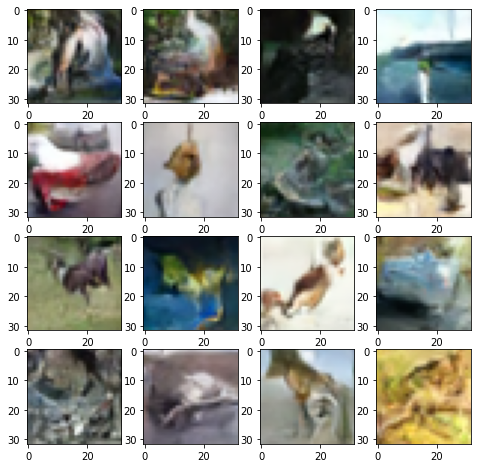

Several commits (2) will be pushed upstream.


  0%|          | 0/196 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [33]:
global_step = 0
for epoch in range(args.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
    progress_bar.set_description(f"Epoch {epoch}")
    # for step, batch in enumerate(train_dataloader):
    for batch, _ in (train_dataloader):
        # clean_images = batch["input"]
        clean_images = batch #["input"]
        # Sample noise that we'll add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bsz = clean_images.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bsz,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        with accelerator.accumulate(model):
            # Predict the noise residual
            noise_pred = model(noisy_images, timesteps)["sample"]
            loss = F.mse_loss(noise_pred, noise)
            accelerator.backward(loss)

            accelerator.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            lr_scheduler.step()
            if args.use_ema:
                ema_model.step(model)
            optimizer.zero_grad()

        progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
        if args.use_ema:
            logs["ema_decay"] = ema_model.decay
        progress_bar.set_postfix(**logs)
        accelerator.log(logs, step=global_step)
        global_step += 1
    progress_bar.close()

    accelerator.wait_for_everyone()

    # Generate sample images for visual inspection
    # if accelerator.is_main_process:
    if epoch % args.save_images_epochs == 0 or epoch == args.num_epochs - 1:
        pipeline = DDPMPipeline(
            unet=accelerator.unwrap_model(ema_model.averaged_model if args.use_ema else model),
            scheduler=noise_scheduler,
        )

        generator = torch.manual_seed(0)
        # run pipeline in inference (sample random noise and denoise)
        images = pipeline(generator=generator, batch_size=args.eval_batch_size, output_type="numpy")["sample"]

        # denormalize the images and save to tensorboard
        images_processed = (images * 255).round().astype("uint8")
        imgs_t = images_processed.transpose(0, 3, 1, 2)
        imgs_plt = images_processed.transpose(0, 1, 2, 3)

        fig = plt.figure(figsize=(8, 8))
        columns = 4
        rows = 4
        for i in range(1, columns*rows +1):
            img = imgs_plt[i-1]
            fig.add_subplot(rows, columns, i)
            plt.imshow(img)
        plt.show()

    if epoch % args.save_model_epochs == 0 or epoch == args.num_epochs - 1:
        # save the model
        # if args.push_to_hub:
        push_to_hub(args, pipeline, repo, commit_message=f"Epoch {epoch}", blocking=False)
        !cd diffusion_cifar && pwd && git push
        # else:
        pipeline.save_pretrained(args.output_dir)

    accelerator.wait_for_everyone()

accelerator.end_training()

### Train DDPM

In [ ]:
# del ddpm
import torch
import gc
gc.collect()
torch.cuda.empty_cache()
torch.cuda.synchronize()
# torch.cuda.memory_summary(device=None, abbreviated=False)
!nvidia-smi